In [4]:
import tensorflow as tf #imports tensorflow as tf. Tensorflow is an n-dimensional matrix, just like a 1-D vector, 2-D array, 3-D array etc.
import numpy as np #imports numpy as np. Numpy is used for basic matrix multiplication, addition.
from tensorflow.examples.tutorials.mnist import input_data #imports mnist input data from tensorflow examples. 
#Mnist data set consists of images of numbers from 0-9, each image is a 28*28 dimensional. There are total 60k training images and 10k test images.
mnist = input_data.read_data_sets("MNIST/data", one_hot = True) #using input data call read data sets from a folder MNIST/data and store in mnist.
#one hot vector is used which means at once only one class will be true. Since our images have labels 0-9 that means out of all 10 classes only 1 class will be true at a time rest all will be zero.

Extracting MNIST/data/train-images-idx3-ubyte.gz
Extracting MNIST/data/train-labels-idx1-ubyte.gz
Extracting MNIST/data/t10k-images-idx3-ubyte.gz
Extracting MNIST/data/t10k-labels-idx1-ubyte.gz


In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

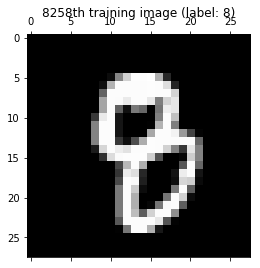

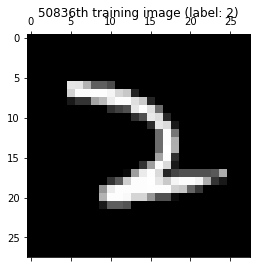

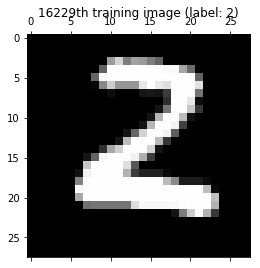

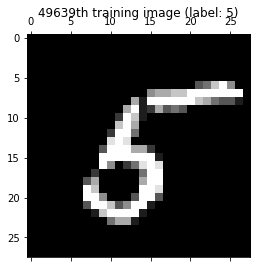

In [6]:
nsample = 4
rand_idx = np.random.randint(mnist.train.images.shape[0], size=nsample)

for i in rand_idx:
    curr_img = np.reshape(mnist.train.images[i, :], (28,28))
    curr_lbl = np.argmax(mnist.train.labels[i, :])
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title(""+str(i)+"th training image "
              + "(label: " + str(curr_lbl) + ")")
    plt.show()

In [2]:
# Parameters
learning_rate = 0.001 #learning rate is used to reduce our cost/loss/cross entropy and helps in converging or reaching the local optima. The learning rate should neither be too high or too low it should be a balanced rate. 
training_iters = 200000 ##number of times we train our network, its like a loop which trains our network, calculates cost, optimizes it in every epoch, also in every epoch we take 
batch_size = 128 #this means that our training images will be divided in a fixed batch size and at every batch it will take a fixed number of images and train them. 
display_step = 10 #after how many epochs we want to output our desired results on screen


# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units, basically it helps in preventing overfitting our data

# tf Graph input
#placeholder is like a variable to which we will assign data later on. It will allow us to do operations and build our computation graph without feeding in data.
#x will hold the training images in form of matrix,the dimensions of x will be in our case None*784, that is why we use None which allows us to vary the dimensionality of our rows.
#we use float to define its type.
x = tf.placeholder("float", [None, n_input])
#similarly y will hold the label of the training images in form matrix which will be a None*10 matrix. None will be replaced by the number of images we want to train on.
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability), this drops some part of our network, so that it helps in backpropogation as computation increases and it also reduces vanishing gradient problem.

In [ ]:
 #Input Image (28*28*1) -> Conv1(32 5*5*1) ->Conv1 (28*28*32)-> Maxpooling(2*2) -> Conv1 (14*14*32)
 
 #Conv1 (14*14*32) -> Conv2 (64 5*5*32) -> Conv2 (14*14*64) -> Maxpooling(2*2) -> Conv2 (7*7*64)
    
 #Conv2 (7*7*64) -> Fully Connected (1024 7*7*64) -> Output Layer (1024 * 10) -> Predict Class    

In [3]:
# Create some wrappers for simplicity
#Note the strides are set to 1 in all dimensions.The first and last stride must always be 1,because the first is for the image-number and the last is for the input-channel.the last is for the input-channel.
#For e.g. strides=[1, 2, 2, 1] would mean that the filter is moved 2 pixels across the x- and y-axis of the image.
#The padding is set to 'SAME' which means the input image is padded with zeroes so the size of the output is the same.
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) #apply relu to the image after doing the dot product with the filter and adding bias.

#This is 2x2 max-pooling, which means that we consider 2x2 windows and select the largest value in each window. Then we move 2 pixels to the next window.
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    #x will recieve a tensor of dimension (None, 784), 784 dimension after flattening the image. 
    # 28,28 is the size of the image; the dimension will reduce. 1 is the number of channels in input image.
    # -1 squashes/flattens the 28*28 input image in to a 1*784 column vector.
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix from a 28*28 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix from a 14*14 matrix.
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term, return the value and get a class prediction 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [6]:
# Store layers weight & bias
#We pass 32 5*5*1 filter through our input image which is wc1, then we pass another 64 5*5*32 filter after which we pass a 1024 7*7*64 fully connected layer and finally a output layer with 1024*10 dimensions. We use 10 because we have 0-9 10 different classes in our model.
#Our input image has 1 channel since its a gray scale image and so our first filter has 5*5*1 dimensions, if it would have been a RGB color image then the filter dimension would have been 5*5*3.
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs, since after max pooling on 28*28 we get 14*14 and then again pooling it to 7*7 we apply a fully connected layer with dimensions of 7*7*64.
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}
#similarly we have 2 bias for our filters, 1 for the fully connected layer and 1 for the output layer.
biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model and we call the conv_net function by passing in x, weights and biases and keep_probability.
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer. We use softmax loss function which is known as cross entropy loss function.
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
#for optimization we use Adam optimizer, we can use Gradient Descent as well.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


# Evaluate model
# Test model, here we check whether the index of the maximum value of the predicted image is equal to the actual labelled image and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#calculate accuracy across the correct_prediction using reduce_mean. For eg: if we have 10 classes and out of which only 4 classes predicted result was true so we will get something like 4/10 as accuracy.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [7]:
# Launch the graph. #this is a class that runs all the tensorflow operations and launches the graph in a session. All the operations have to be within the indentation. 
with tf.Session() as sess:
    sess.run(init) #sess.run(init), runs the variables that were initialised in the previous step and evaluates the tensor 

#instead of using for loop we use while loop and intialize step = 1 and at every time step we increment step = step + 1.
#since our batch size is 128 and display step is 10 so we display our output for only those Iterations where the Step after dividing by the display_Step leaves a remainder zero.
#we then input the images in batch_x and their respective labels in batch_y and run an optimizer by feeding in x, y, and dropout. Here are placeholders x,y,and keep_prob gets their value.
#after that we display the Iteration number, the Minibatch loss and the training accuracy by calling the cost and the accuracy function.
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop), we use keep_prob to drop some part of the network and as dropout is 0.75, so it will keep 75% of the network and drop the 25%, which helps in reducing the computational complexity and vanishing gradient problem while backpropogating through the network.
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 250 mnist test images
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:250],y : mnist.test.labels[:250],keep_prob: 1.}))  

Iter 1280, Minibatch Loss= 31540.179688, Training Accuracy= 0.33594
Iter 2560, Minibatch Loss= 10024.594727, Training Accuracy= 0.53906
Iter 3840, Minibatch Loss= 7291.990234, Training Accuracy= 0.59375
Iter 5120, Minibatch Loss= 5686.883789, Training Accuracy= 0.71875
Iter 6400, Minibatch Loss= 6301.837891, Training Accuracy= 0.75000
Iter 7680, Minibatch Loss= 2591.784668, Training Accuracy= 0.82812
Iter 8960, Minibatch Loss= 3040.357910, Training Accuracy= 0.87500
Iter 10240, Minibatch Loss= 2686.399170, Training Accuracy= 0.85156
Iter 11520, Minibatch Loss= 2853.360840, Training Accuracy= 0.85156
Iter 12800, Minibatch Loss= 2102.417236, Training Accuracy= 0.86719
Iter 14080, Minibatch Loss= 2391.098633, Training Accuracy= 0.85938
Iter 15360, Minibatch Loss= 1695.261963, Training Accuracy= 0.89844
Iter 16640, Minibatch Loss= 1993.429565, Training Accuracy= 0.87500
Iter 17920, Minibatch Loss= 1933.289307, Training Accuracy= 0.86719
Iter 19200, Minibatch Loss= 2038.959229, Training Acc

Iter 157440, Minibatch Loss= 123.597115, Training Accuracy= 0.97656
Iter 158720, Minibatch Loss= 51.359531, Training Accuracy= 0.97656
Iter 160000, Minibatch Loss= 42.420990, Training Accuracy= 0.99219
Iter 161280, Minibatch Loss= 140.845337, Training Accuracy= 0.98438
Iter 162560, Minibatch Loss= 307.216980, Training Accuracy= 0.96875
Iter 163840, Minibatch Loss= 67.892838, Training Accuracy= 0.98438
Iter 165120, Minibatch Loss= 28.960442, Training Accuracy= 0.99219
Iter 166400, Minibatch Loss= 130.503799, Training Accuracy= 0.96094
Iter 167680, Minibatch Loss= 6.974297, Training Accuracy= 0.99219
Iter 168960, Minibatch Loss= 123.338348, Training Accuracy= 0.96875
Iter 170240, Minibatch Loss= 116.928535, Training Accuracy= 0.98438
Iter 171520, Minibatch Loss= 517.482605, Training Accuracy= 0.96094
Iter 172800, Minibatch Loss= 332.341858, Training Accuracy= 0.99219
Iter 174080, Minibatch Loss= 203.065445, Training Accuracy= 0.95312
Iter 175360, Minibatch Loss= 162.362946, Training Accu